https://machinelearningmastery.com/understanding-simple-recurrent-neural-networks-in-keras/

In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('Vietcombank.csv')
df1=df.reset_index()['Close']

In [3]:
df1.shape

(1306,)

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)


(943, 100)
(943,)
(161, 100)
(161,)


In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [10]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [11]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 2s 38ms/step - loss: 0.0817 - val_loss: 0.1314
Epoch 2/100
15/15 [==============================] - 0s 19ms/step - loss: 0.0066 - val_loss: 0.0278
Epoch 3/100
15/15 [==============================] - 1s 35ms/step - loss: 0.0023 - val_loss: 0.0060
Epoch 4/100
15/15 [==============================] - 1s 35ms/step - loss: 0.0011 - val_loss: 0.0060
Epoch 5/100
15/15 [==============================] - 1s 43ms/step - loss: 9.8296e-04 - val_loss: 0.0068
Epoch 6/100
15/15 [==============================] - 1s 38ms/step - loss: 9.1148e-04 - val_loss: 0.0065
Epoch 7/100
15/15 [==============================] - 1s 44ms/step - loss: 8.5336e-04 - val_loss: 0.0068
Epoch 8/100
15/15 [==============================] - 1s 43ms/step - loss: 8.1820e-04 - val_loss: 0.0064
Epoch 9/100
15/15 [==============================] - 1s 36ms/step - loss: 7.9431e-04 - val_loss: 0.0061
Epoch 10/100
15/15 [==============================] - 1s 34ms/step - loss: 7.771

In [12]:
# 10. Dự báo dữ liệu test,
train_predict=model.predict(X_train)
y_pred=model.predict(test_data.reshape(test_data.shape[0],test_data.shape[1] , 1))


9/9 [==============================] - 0s 2ms/step


In [13]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)


In [14]:
ytest=scaler.inverse_transform(test_data)
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(ytest - y_pred)/np.abs(ytest))*100

print('Testing MAPE:', test_mape)

# Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 17205.253889103482
Testing MAPE: 19.40121059554105
Testing MAE: 17119.406309875954


In [15]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape

(1, 202)

In [16]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=202
i=0
while(i<90):

    if(len(temp_input)>202):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


(1, 202)
[0.81490207]
203
1 day input [0.88896868 0.88728639 0.87887492 0.85027595 0.88223951 0.85868741
 0.85700512 0.862052   0.86541658 0.86709888 0.87214575 0.84859366
 0.81326551 0.82504156 0.81158322 0.82504156 0.84859366 0.8603697
 0.8603697  0.87719263 0.87887492 0.86709888 0.86709888 0.85027595
 0.87382805 0.8603697  0.8603697  0.87214575 0.85532283 0.84354678
 0.84186449 0.82504156 0.86373429 0.86373429 0.82504156 0.8384999
 0.84186449 0.83345302 0.81663009 0.81326551 0.81326551 0.78298424
 0.79812487 0.78466653 0.80990092 0.81663009 0.80821863 0.81831239
 0.80990092 0.80653634 0.80653634 0.78298424 0.78803112 0.78298424
 0.80821863 0.80485405 0.78298424 0.7913957  0.80653634 0.82167697
 0.8384999  0.85868741 0.85700512 0.86709888 0.84691136 0.86709888
 0.84018219 0.80821863 0.79980717 0.80821863 0.83681761 0.84186449
 0.80148946 0.80990092 0.81831239 0.81999468 0.79980717 0.80821863
 0.80485405 0.80485405 0.793078   0.78634883 0.7913957  0.80821863
 0.79812487 0.80653634 0.7

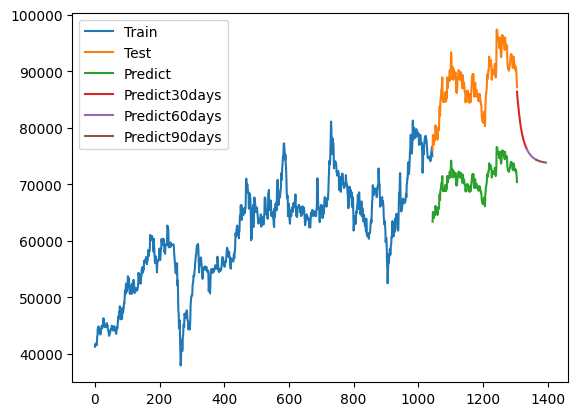

In [17]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred)


prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Train','Test','Predict','Predict30days', 'Predict60days', 'Predict90days'])
plt.show()

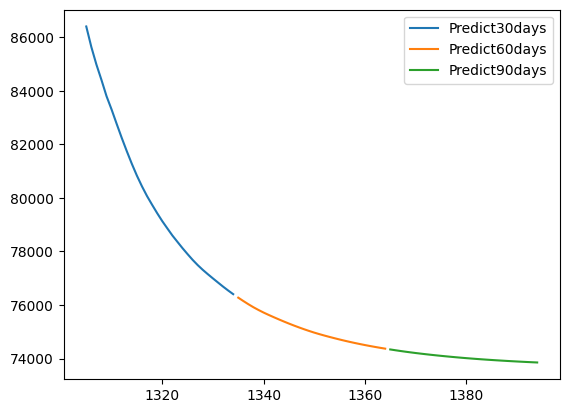

In [18]:
# 14.Vẽ hình
# Dự đoán 90 ngày tiếp theo

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Predict30days', 'Predict60days', 'Predict90days'])
plt.show()


In [19]:
print(scaler.inverse_transform(lst_output))

[[86397.28142275]
 [85632.23196108]
 [84977.2724682 ]
 [84400.78821731]
 [83794.063947  ]
 [83296.3667274 ]
 [82761.14849951]
 [82237.72511927]
 [81740.20859574]
 [81266.43057605]
 [80825.10344539]
 [80426.00959319]
 [80062.32154229]
 [79738.46811804]
 [79424.92145613]
 [79128.99797601]
 [78858.68373555]
 [78592.39795462]
 [78354.47082811]
 [78118.74394203]
 [77896.44879745]
 [77681.88815344]
 [77486.74702279]
 [77309.77824827]
 [77147.17304011]
 [76990.46348424]
 [76836.98165627]
 [76684.83201897]
 [76540.05194704]
 [76402.46428746]
 [76271.51277977]
 [76146.48881192]
 [76026.44992987]
 [75913.73101035]
 [75811.23381972]
 [75715.59245071]
 [75627.6749531 ]
 [75543.37846308]
 [75461.45582345]
 [75381.53146981]
 [75304.45573664]
 [75230.52624098]
 [75160.07957358]
 [75092.10241918]
 [75027.68604036]
 [74966.79500651]
 [74910.46743429]
 [74857.21523838]
 [74806.50695976]
 [74757.40014438]
 [74710.02234241]
 [74664.38063997]
 [74621.07027119]
 [74579.6518966 ]
 [74540.25660943]
 [74502.50